# Part 3: Reinforcement Learning for Particle Accelerators

In this part of the workshop we will have a look at Reinforcement Learning (RL) and see how to apply it in practice, including a brief example looking at RL for accelerator optimisation.

### Content

 0. Introduction to RL
 1. Practical example of applying RL on the well-known lunar lander task
 2. Practical example of applying RL to a tuning task at the ARES particle accelerator
 3. Further resources

## 0. Introduction to Reinforcement Learning

Reinforcement learning (RL) is a subfield of machine learning (ML), or more specifically a method of training ML models.

The idea of RL is to learn by trial and error, where one wants to perform good actions that give high rewards more often and bad actions that give low rewards less often.

### What can RL do?

Here are some examples of what can be done with RL:

 - Control robots in simulation
 - [Play games with imperfect information and develop long-term startegies](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)
 - [Control robot hands in the real world](https://openai.com/blog/learning-dexterity/)
 - [Control the plasma in a tokamak fusion reactor](https://www.deepmind.com/blog/accelerating-fusion-science-through-learned-plasma-control)

<img src="img/humanoid.gif" width="24%"/>
<img src="img/alphastar.gif" width="24%"/>
<img src="img/learning_dexterity.gif" width="24%"/>
<img src="img/magnetic_plamsa_control.gif" width="24%"/>

### Key Concepts of RL

At the heart of RL is the RL loop shown below that illustrates the relationships and interactions between entities in RL.

<img src="img/rl_loop.jpg" width="65%"/>

The following are the key entities and concepts in RL:

 - The **environment** is the world that the RL agent lives in and interacts with. It may be something as simple as the simulation of a robot or something more complex like a particle accelerator in the real world.
 - **Actions** are how the RL agent interacts with the environment. The can either be discrete (e.g. pressing any of a limited number of buttons) or continuous (setting a limited number of actuators to a certain value).
 - **Observations** determine how the agent sees the environment. This may, for example, be an image from a camera or the measured values from a number of sensors.
 - The **state** of the environment is not always fully observed via the observations. In that case, we speak of a partially-observable environment (POMDP).
 - The **reward** is returned by the environment after each action. And describes the goodness of that action.
 - The **return** is the cummulative reward over time. The goal of RL is to maximise the return.
 - The agent uses a function called **policy** to compute the next action from an observation. Finding the optimal policy of RL that maximises the return is the goal of RL. When talking about RL, we often look at deep RL, where an artificial neural network (ANN) is uses to approximate the optimal policy.

 ### Algorithms

 In RL we have a large number of algorithms to train the policy and new ones are introduced all the time. Below is a non-exhaustive taxonomy of these algorithms (source [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html))

 <img src="img/rl_taxonomy.png" width="65%"/>

## 1. Lunar Lander Example

In this example, we will train an RL agent on the popular *Lunar Lander* environment. We will be using an implementation of the on-policy algorithm [Proximal Policy Optimisation (PPO)](https://spinningup.openai.com/en/latest/algorithms/ppo.html) provided by the Stable Baselines3 library.

The goal in this task is to savely land a lunar lander on the moon, ideally on a landing pad at position (0,0) in the randomly generated lunar landscape.

### Action

The agent can control the lunar lander by firing the main engine and two thrusters, one on each side of the lander.

### Observation

The agent can observe the lander's position and velocity in x and y, the landars orientation angle and angular velocity as well as whether the lander's legs are currently touching the ground.

### Reward

The lander receives negative rewards for moving away from the landing pad. Crashing is punished with a reward of -100. For each leg touching the ground, the lander receives +10 reward. When coming to rest anywhere on the ground, the lander receives +100 points. When coming to rest on the landing pad, the lander receives +200 points. Using fuel gives negative reward with the main engine costing -0.3 when fired and the side thrusters costing -0.03 when fired.

In [2]:
# Imports

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

from utils.rl.helpers import display_ll_training_videos, plot_ll_training_metrics, record_video

First we need to create the environment. Environments contained in *Gym* can be created by running

```python
env = gym.make("LunarLander-v2")
```

with the environment's name. In order to facilitate faster training using multiple CPU cores, we use a so-called *vectorised environment*, where multiple of the same environment run in parallel. *Stable Baselines3* offers a convenience function `make_vec_env` to create vectorised versions of Gym environments.

In [3]:
venv = make_vec_env("LunarLander-v2", n_envs=16, vec_env_cls=SubprocVecEnv)
eval_venv = make_vec_env("LunarLander-v2", wrapper_class=record_video, monitor_dir="utils/rl/lunar_lander_evaluations", vec_env_cls=SubprocVecEnv)

/opt/homebrew/Caskroom/miniforge/base/envs/mt-ard-st3-ml-workshop/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/2022-MT-ARD-ST3-ML-workshop/utils/rl/lunar_lander_recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Then we create our PPO agent. These objects are the key component of Stable Baselines3 and contain the implementations of the RL algorithms as well as other utilities to handle inference, model saving and more.

The agent is configured to use a multi-layer perceptron (MLP) as its policy, the previously created environment for training and a number of known-to-work-well hyperparameters.

In [4]:
model = PPO("MlpPolicy", env=venv, n_steps=1024, batch_size=64, gae_lambda=0.98, gamma=0.999, n_epochs=4, ent_coef=0.01)

Now we can train. Training length/budget is measured in number of timesteps (interactions with the environment). 1 Million steps is known to work well for this particular example.

In [4]:
model.learn(total_timesteps=int(1e6), eval_env=eval_venv, eval_freq=int(1e3))

2022-07-28 16:45:04.760 python[83448:5360860] Error received in message reply handler: Connection invalid
2022-07-28 16:45:04.760 python[83448:5360894] Connection Invalid error for service com.apple.hiservices-xpcservice.
2022-07-28 16:45:04.773 python[83448:5360860] +[NSXPCSharedListener endpointForReply:withListenerName:]: an error occurred while attempting to obtain endpoint for listener 'ClientCallsAuxiliary': Connection invalid


Eval num_timesteps=16000, episode_reward=-322.36 +/- 73.39
Episode length: 67.40 +/- 9.02
New best mean reward!
Eval num_timesteps=32000, episode_reward=-237.17 +/- 123.72
Episode length: 66.60 +/- 7.71
New best mean reward!
Eval num_timesteps=48000, episode_reward=39.09 +/- 69.58
Episode length: 173.40 +/- 132.37
New best mean reward!
Eval num_timesteps=64000, episode_reward=53.39 +/- 196.87
Episode length: 246.40 +/- 58.63
New best mean reward!
Eval num_timesteps=80000, episode_reward=-309.60 +/- 26.32
Episode length: 388.00 +/- 68.33
Eval num_timesteps=96000, episode_reward=-122.76 +/- 189.30
Episode length: 507.60 +/- 212.94
Eval num_timesteps=112000, episode_reward=-235.64 +/- 41.98
Episode length: 387.20 +/- 193.46
Eval num_timesteps=128000, episode_reward=-129.56 +/- 161.69
Episode length: 452.40 +/- 112.32
Eval num_timesteps=144000, episode_reward=-12.35 +/- 114.88
Episode length: 486.60 +/- 315.32
Eval num_timesteps=160000, episode_reward=-203.17 +/- 72.02
Episode length: 464.

Let's checkout how the episode reward and episode length developed throughout the training.

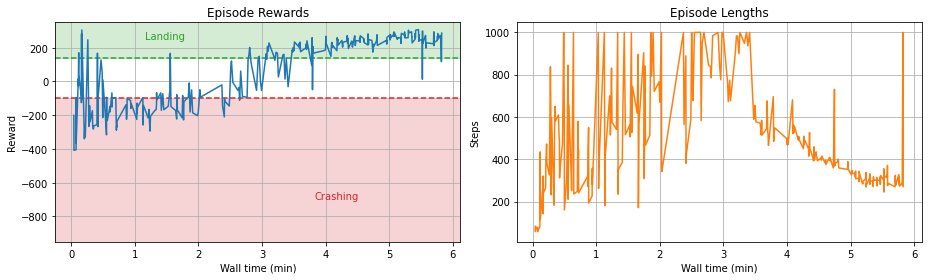

In [6]:
plot_ll_training_metrics()

We can also look at the agent trying to land the lunar lander at different stages of the training.

In [7]:
display_ll_training_videos()

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

Training usually takes longer, so we want to save the model for later use.

In [8]:
model.save("utils/rl/lunar_lander_model")

Now we can load the trained model and try it.

In [10]:
loaded_model = PPO.load("utils/rl/lunar_lander_model")
env = gym.make("LunarLander-v2")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
env.close()

## 2. Reinforcement Learning for Particle Accelerators

In much the same way we just used RL to train an agent to land a lunar lander, we can also train agents to control particle accelerators. We will take a look at an example close to [one of our papers](https://proceedings.mlr.press/v162/kaiser22a.html).

The goal is to tune the magnets of a section of the accelerator such that we achieve certain beam parameters on a diagnostic screen. Below you can see what the RL loop would look like for this example.

<img src="img/ares_ea_rl_loop.png" width="65%"/>

Because training on the actual accelerator would take too much already scarce beam time, we want to train the RL agent using a simulation. After training the agent must then be able to also work on the real accelerator.

In the following we will briefly demonstrate what a training for this problem might look like on a focusing task only. Then we will briefly demostrate a trained agent successfully tackling both focusing and positioning.

**Note** than the training for these tasks longer than it did for the lunar lander, so while we provide all the code needed for training, we will not run it, but present agents we have prepared earlier.

### Setup

To achieve training in simulation and using the trained agent on the real aceelerator, we implement two seperate environments: `ARESEACheetah` to run on top of the *Cheetah* simulation code and `ARESEADOOCS` to communicate with the real accelerator. Both provide the same outside interface, meaning that to the RL agent they appear to be exactly the same and the agent can seamlessly be used on either environment.

In [1]:
# Imports

from functools import partial
import os
from time import sleep

from gym.wrappers import FilterObservation, FlattenObservation, FrameStack, RecordVideo, RescaleAction, TimeLimit
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize

from utils.rl.helpers import (
    ARESEACheetah,
    display_acc_training_videos,
    display_video,
    FilterAction,
    NotVecNormalize,
    optimize,
    plot_acc_training_metrics,
    read_from_yaml,
    save_to_yaml
)

initializing ocelot...


Being a new task that is not as well understood in the RL community as the lunar lander, there is a lot of tuning of the environment, the agent interaction, observation and reward definition one has to do. For fast iteration over experiments and easy experiment tracking, we use a `config` dictionary.

In [2]:
config = {
    "action_mode": "direct",
    "gamma": 0.99,
    "filter_action": [0, 1, 3],  
    "filter_observation": None,
    "frame_stack": None,
    "incoming_mode": "random",
    "incoming_values": None,
    "magnet_init_mode": "constant",
    "magnet_init_values": np.array([10, -10, 0, 10, 0]),
    "misalignment_mode": "constant",
    "misalignment_values": np.zeros(8),
    "n_envs": 40,
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "feedback",
    "sb3_device": "auto",
    "target_beam_mode": "constant",
    "target_beam_values": np.zeros(4),
    "target_mu_x_threshold": np.inf,
    "target_mu_y_threshold": np.inf,
    "target_sigma_x_threshold": 1e-4,
    "target_sigma_y_threshold": 1e-4,
    "threshold_hold": 5,
    "time_limit": 25,
    "vec_env": "subproc",
    "w_done": 50.0,
    "w_mu_x": 0.0,
    "w_mu_x_in_threshold": 0.0,
    "w_mu_y": 0.0,
    "w_mu_y_in_threshold": 0.0,
    "w_on_screen": 0.0,
    "w_sigma_x": 1.0,
    "w_sigma_x_in_threshold": 1.0,
    "w_sigma_y": 1.0,
    "w_sigma_y_in_threshold": 1.0,
    "w_time": 0.0,
}

In Gym, so-called wrappers make it easy to modify some of the environment behaviour without modifying the environment itself. This makes it easy to leave out some of the observation, do normalisation, limit episodes to certain lengths and more.

For our more advanced example, we use these wrappers depending on some entry in the config dictionary and imlemented a function to do all of this automatically.

In [3]:
# Setup environments
def make_env(config, record_video=False, monitor_filename=None):
    env = ARESEACheetah(
        incoming_mode=config["incoming_mode"],
        incoming_values=config["incoming_values"],
        misalignment_mode=config["misalignment_mode"],
        misalignment_values=config["misalignment_values"],
        action_mode=config["action_mode"],
        magnet_init_mode=config["magnet_init_mode"],
        magnet_init_values=config["magnet_init_values"],
        reward_mode=config["reward_mode"],
        target_beam_mode=config["target_beam_mode"],
        target_beam_values=config["target_beam_values"],
        target_mu_x_threshold=config["target_mu_x_threshold"],
        target_mu_y_threshold=config["target_mu_y_threshold"],
        target_sigma_x_threshold=config["target_sigma_x_threshold"],
        target_sigma_y_threshold=config["target_sigma_y_threshold"],
        threshold_hold=config["threshold_hold"],
        w_mu_x=config["w_mu_x"],
        w_mu_x_in_threshold=config["w_mu_x_in_threshold"],
        w_mu_y=config["w_mu_y"],
        w_mu_y_in_threshold=config["w_mu_y_in_threshold"],
        w_on_screen=config["w_on_screen"],
        w_sigma_x=config["w_sigma_x"],
        w_sigma_x_in_threshold=config["w_sigma_x_in_threshold"],
        w_sigma_y=config["w_sigma_y"],
        w_sigma_y_in_threshold=config["w_sigma_y_in_threshold"],
        w_time=config["w_time"],
    )
    if config["filter_observation"] is not None:
        env = FilterObservation(env, config["filter_observation"])
    if config["filter_action"] is not None:
        env = FilterAction(env, config["filter_action"], replace=0)
    if config["time_limit"] is not None:
        env = TimeLimit(env, config["time_limit"])
    env = FlattenObservation(env)
    if config["frame_stack"] is not None:
        env = FrameStack(env, config["frame_stack"])
    if config["rescale_action"] is not None:
        env = RescaleAction(env, config["rescale_action"][0], config["rescale_action"][1])
    if not os.path.exists("utils/rl/accelerator_evaluations"):
        os.mkdir("utils/rl/accelerator_evaluations")
    env = Monitor(env, filename=monitor_filename)
    if record_video:
        env = RecordVideo(env, video_folder="utils/rl/accelerator_recordings")
    return env
    

if config["vec_env"] == "dummy":
    env = DummyVecEnv([partial(make_env, config) for _ in range(config["n_envs"])])
elif config["vec_env"] == "subproc":
    env = SubprocVecEnv([partial(make_env, config) for _ in range(config["n_envs"])])
else:
    raise ValueError(f"Invalid value \"{config['vec_env']}\" for dummy")
eval_env = DummyVecEnv([partial(make_env, config, record_video=True, monitor_filename="utils/rl/accelerator_evaluations/0")])

initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...
initializing ocelot...


/opt/homebrew/Caskroom/miniforge/base/envs/mt-ard-st3-ml-workshop/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/2022-MT-ARD-ST3-ML-workshop/utils/rl/accelerator_recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Normalisation of inputs and outputs is a key concept in ML and helps train models faster and better. This holds true for RL as well, so we use a wrapper to normalise observations of rewards comming from the environment. As we don't have full data set to compute the correct scaler from ahead of time, we use running mean and standard deviation to adjust the scale during training.

In [4]:
if config["normalize_observation"] or config["normalize_reward"]:
    env = VecNormalize(
        env,
        norm_obs=config["normalize_observation"],
        norm_reward=config["normalize_reward"],
        gamma=config["gamma"],
    )
    eval_env = VecNormalize(
        eval_env,
        norm_obs=config["normalize_observation"],
        norm_reward=config["normalize_reward"],
        gamma=config["gamma"],
        training=False,
    )

We use the same PPO algorithm that we used for the lunar lander.

In [5]:
# Train
model = PPO(
    "MlpPolicy",
    env,
    device=config["sb3_device"],
    gamma=config["gamma"],
    n_steps=100,
    batch_size=100,
)

Training also works in very much the same way.

In [6]:
model.learn(
    # total_timesteps=int(2e6),
    total_timesteps=50000,
    eval_env=eval_env,
    eval_freq=500,
)

Eval num_timesteps=20000, episode_reward=-5.08 +/- 19.81
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-33.42 +/- 18.85
Episode length: 25.00 +/- 0.00


After training we don't just need to save the model. The normalisation scalers are also required to use the model later. We also save the `config` dictionary so that we can easily restore the configuration that was used during training.

In [7]:
model.save("utils/rl/accelerator_model")

if config["normalize_observation"] or config["normalize_reward"]:
    env.save("utils/rl/accelerator_normalizer.pkl")
save_to_yaml(config, "utils/rl/accelerator_config")

As before we can look at the training metrics and check out videos taken at different stages of the training.

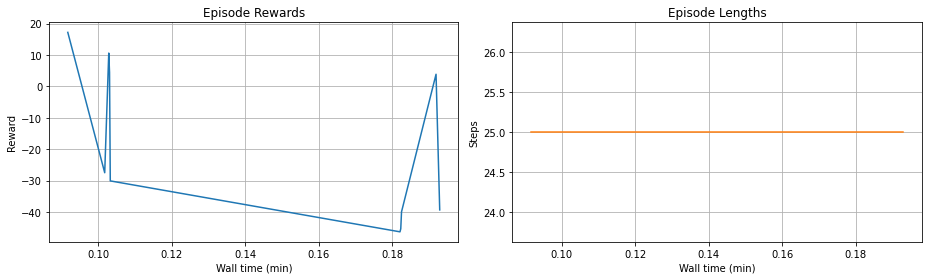

In [8]:
# Training curves from this training
plot_acc_training_metrics()

In [9]:
# Videos from this training
display_acc_training_videos()

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

We can also test the trained agent using a the simulation.

In [ ]:
# Run final agent

loaded_model = PPO.load("utils/rl/accelerator_model")
loaded_config = read_from_yaml("utils/rl/accelerator_config")

env = make_env(config)
env = NotVecNormalize(env, "utils/rl/accelerator_normalizer.pkl")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
    sleep(0.5)
env.close()

Next, we load an agent has has been fully training and evaluated in simulation and gone through full evaluation on the real accelerator.

Runs well on dummy of accelerator ...

In [11]:
# Show polished donkey running (on simulation)
optimize(
    target_mu_x=0.0,
    target_sigma_x=0.0,
    target_mu_y=0.0,
    target_sigma_y=0.0,
    max_steps=20,
)

/opt/homebrew/Caskroom/miniforge/base/envs/mt-ard-st3-ml-workshop/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mt-ard-st3-ml-workshop/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/2022-MT-ARD-ST3-ML-workshop/utils/rl/polished-donkey_recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


... and video from the real accelerator.

As you can see, in this (recording) of the agent running on the real accelerator.

In [12]:
# Show polished dinkey running (on real accelerator)
display_video("utils/rl/rl-video-episode-1727.mp4")

## Further Resources

### Getting started in RL
 - [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html) - Very understandable explainations on RL and the most popular algorithms acompanied by easy-to-read Python implementations.
 - [Reinforcement Learning with Stable Baselines 3](https://youtube.com/playlist?list=PLQVvvaa0QuDf0O2DWwLZBfJeYY-JOeZB1) - YouTube playlist giving a good introduction on RL using Stable Baselines3.
 - [Build a Doom AI Model with Python](https://youtu.be/eBCU-tqLGfQ) - Detailed 3h tutorial of applying RL using *DOOM* as an example.
 - [An introduction to Reinforcement Learning](https://youtu.be/JgvyzIkgxF0) - Brief introdution to RL.
 - [An introduction to Policy Gradient methods - Deep Reinforcement Learning](https://www.youtube.com/watch?v=5P7I-xPq8u8) - Brief introduction to PPO.

### Papers

 - [Learning-based optimisation of particle accelerators under partial observability without real-world training](https://proceedings.mlr.press/v162/kaiser22a.html) - Tuning of electron beam properties on a diagnostic screen using RL.
 - [Sample-efficient reinforcement learning for CERN accelerator control](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.23.124801) - Beam trajectory steering using RL with a focus on sample-efficient training.
 - [Autonomous control of a particle accelerator using deep reinforcement learning](https://arxiv.org/abs/2010.08141) - Beam transport through a drift tube linac using RL.
 - [Basic reinforcement learning techniques to control the intensity of a seeded free-electron laser](https://www.mdpi.com/2079-9292/9/5/781/htm) - RL-based laser alignment and drift recovery.
 - [Real-time artificial intelligence for accelerator control: A study at the Fermilab Booster](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.104601) - Regulation of a gradient magnet power supply using RL and real-time implementation of the trained agent using field-programmable gate arrays (FPGAs).
 - [Magnetic control of tokamak plasmas through deep reinforcement learning](https://www.nature.com/articles/s41586-021-04301-9) - Landmark paper on RL for controling a real-world physical system (plasma in a tokamak fusion reactor).

### Literature
 
 - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) - Standard text book on RL.

### Packages
 - [Gym](https://www.gymlibrary.ml) - Defacto standard for implementing custom environments. Also provides a library of RL tasks widely used for benchmarking.
 - [Stable Baslines3](https://github.com/DLR-RM/stable-baselines3) - Provides reliable, benchmarked and easy-to-use implementations of the most important RL algorithms.
 - [Ray RLlib](https://docs.ray.io/en/latest/rllib/index.html) - Part of the *Ray* Python package providing implementations of various RL algorithms with a focus on distributed training.